In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import sys

# Add src to path
sys.path.append("src")
from BWImage import BWImage
from GeometricTransforms import rotate_translate

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

#
%matplotlib inline

# Set white as color for pixels with no value.
BWImage.blank_value = 255 

# Introduction

In this lab we are given two images `IMG1.png` and `IMG2.png` and two point correspondences between them. 
* First we solve the point correspondences to get the geometric transformation to get IMG2 to same configuration as IMG1.

* Following this we, transform IMG2 and take the difference between IMG2 and IMG to reveal the difference between these two images.

#### Implementations
* `BWImage` class is the same from lab-1 and it contains the code for storing an image as numpy array and associated methods. In particular, it contains the method for bilinear interpolation.
* `GeometricTransforms.py` Contains one function `rotate_transform` that takes as input the source image, target image and rotation and translation matrices and performs the geometric transformation.

#### Output
* The source and target images are plotted side-by-side.
* The target images are also stored in `data\output` folder.


We are given two images IMG1 and IMG2. They are related by in-plane translation and rotation.
Let $(x^1_i, y^1_i)$ represent point-$i$ from IMG1 and $(x^2_i, y^2_i)$ represent the corresponding point from IMG2. Given that they are related by in-plane rotation and translation we can assume that they are related by the following equation.



$$
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
=
\begin{bmatrix}
a & -b\\
b & a
\end{bmatrix}

\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}

+

\begin{bmatrix}
t_x\\
t_y
\end{bmatrix}
$$

We are given two point correspondences, $(x^1_1, y^1_1) \to (x^2_1, y^2_1)$ and $(x^1_2, y^1_2)\to (x^2_2, y^2_2)$

We could write this as:

$$
\begin{bmatrix}
x^2_1 & -y^2_1 & 1 & 0\\
y^2_1 & x^2_1 & 0 & 1\\
x^2_2 & -y^2_2 & 1 & 0\\
y^2_2 & x^2_2 & 0 & 1\\
\end{bmatrix}

\begin{bmatrix}
a\\
b\\
t_x\\
t_y
\end{bmatrix}

= 

\begin{bmatrix}
x^1_1\\ 
y^1_1\\ 
x^1_2\\ 
y^1_2 
\end{bmatrix}

$$

We can look at it as $Ma = z$ and get $x$ by $a = M^{-1}z$.

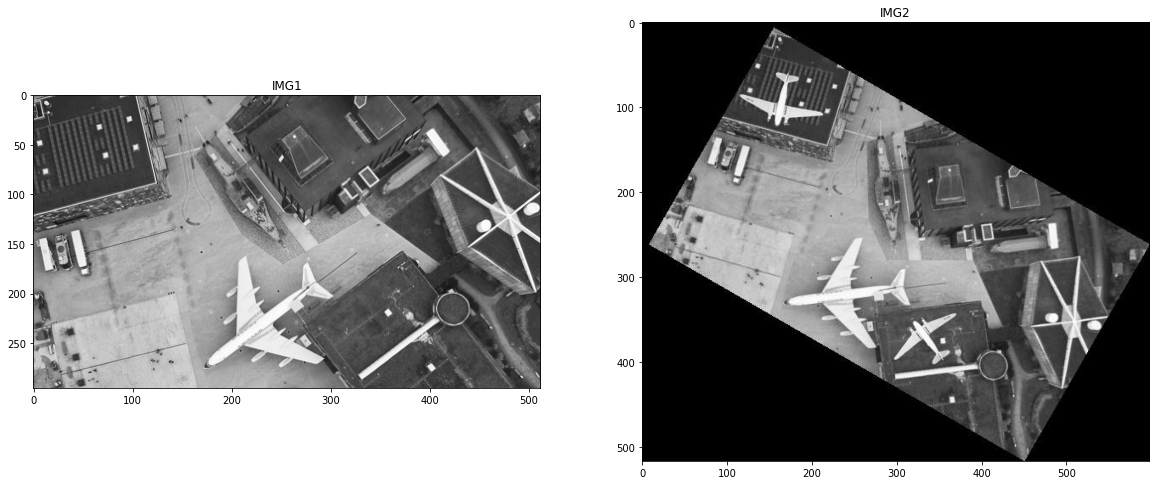

In [11]:
img1 = cv2.imread('data/IMG1.png')
img2 = cv2.imread('data/IMG2.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1);
ax[1].imshow(img2);
ax[0].set_title('IMG1');
ax[1].set_title('IMG2');

# 1. Get the geometric transformation.

In [3]:
## Read point correspondences.
data = np.genfromtxt('data/pt_correspondences.csv', delimiter=',')
p1_1 = data[0][0:2] # NOTE: Here x1 represents the point. 
p2_1 = data[0][2:4]
p1_2 = data[1][0:2] # NOTE: Here x1 represents the point. 
p2_2 = data[1][2:4]

In [4]:
## Solve the point correspondences.
# Ma = z

M = np.zeros((4, 4))
M[0] = np.array([p2_1[0], -1 * p2_1[1], 1, 0]) 
M[1] = np.array([p2_1[1], p2_1[0], 0, 1]) 
M[2] = np.array([p2_2[0], -1 * p2_2[1], 1, 0]) 
M[3] = np.array([p2_2[1], p2_2[0], 0, 1]) 

z = np.array([p1_1[0], p1_1[1], p1_2[0], p1_2[1]])

a = np.linalg.inv(M) @ z

# Obtain R and T (rotation & translation matrices, respectively)
# from a.
R = np.array([[a[0], -1 * a[1]], [a[1], a[0]]])
T = np.array([a[2], a[3]])
T = T.reshape(2, 1)

# Perform transformation and identify the new objects.

In [5]:
# Rotate source image
target = BWImage()
target.make_blank(img1.shape)
source = BWImage(img2)
rotate_translate(source, target, R, T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


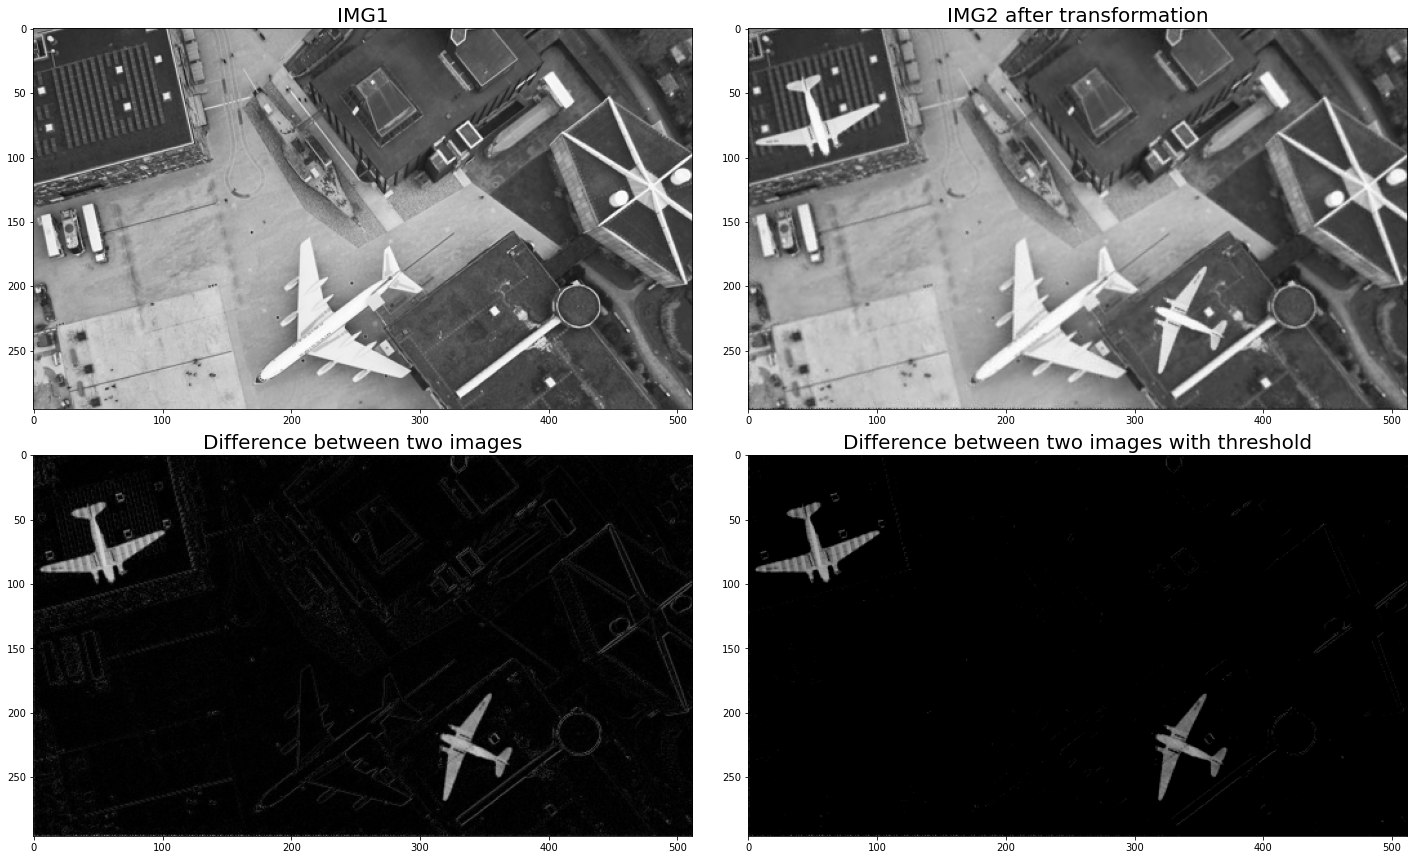

In [20]:
threshold = 35
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax[0, 0].imshow(img1);
ax[0, 1].imshow(target.get_image());
ax[1, 0].imshow(np.abs(target.get_image() - img1));
ax[1, 1].imshow(np.abs(target.get_image() - img1) - threshold);

ax[0, 0].set_title("IMG1", fontsize=20);
ax[0, 1].set_title("IMG2 after transformation", fontsize=20);
ax[1, 0].set_title("Difference between two images", fontsize=20);
ax[1, 1].set_title("Difference between two images with threshold", fontsize=20);
fig.tight_layout();